# Projekt: Analiza ruchu DoH

**Wykonanie:** Dominik Błaszczyk (249429), Sebastian Słodki (249307)
**Kurs**:
Metody AI w badaniu zagrożeń w systemach komputerowych
**Prowadzący:** Dr inż. Tomasz Walkowiak
**Data:** 4-6.2023

# 1. Wstęp


**DNS (Domain Name System)** jest rozproszonym systemem komputerowym, który przyporządkowuje nazwy domenowe (np. example.com) do adresów IP (np. 192.0.2.1). Działa jako tłumacz, umożliwiając użytkownikom korzystanie z łatwych do zapamiętania nazw domenowych zamiast pamiętania skomplikowanych adresów IP.

Kiedy użytkownik wpisuje nazwę domenową, aplikacja klienta wysyła zapytanie do serwera DNS. Serwer DNS przeszukuje hierarchiczną strukturę DNS, aby odnaleźć odpowiedni rekord DNS dla danej domeny i zwraca adres IP przypisany do tej nazwy. Dzięki temu, użytkownicy mogą komunikować się z serwerami i urządzeniami w sieci za pomocą znanych im nazw domenowych.

DNS jest istotnym elementem infrastruktury internetowej, umożliwiającym nawigację w Internecie i skuteczne odnajdywanie zasobów sieciowych. Posiada kilka luk bezpieczeństwa, wielokrotnie wykorzystywanych na przestrzeni lat. Nadużywanie DNS zawsze było obszarem dużego zainteresowania badaczy cyberbezpieczeństwa. Jednak zapewnienie bezpieczeństwa i prywatności żądaniom i odpowiedziom DNS jest nadal trudnym zadaniem, ponieważ napastnicy używają wyrafinowanych metodologii ataku, aby wykradać informacje.

Aby przezwyciężyć niektóre z luk w DNS związanych z prywatnością i manipulacją danymi, IETF wprowadził **DNS over HTTPS (DoH)** w RFC8484 - protokół, który zwiększa prywatność i zwalcza możliwość podsłuchiwania oraz ataki man-in-the-middle poprzez szyfrowanie zapytań DNS i wysyłanie ich w zaszyfrowanym kanale.

Podczas gdy przedstawiono wiele przykładów dotyczących aspektów zastosowania i wydajności
DoH, badania nad aspektami bezpieczeństwa DoH pozostają ograniczone - tunele DNS były i są
szeroko wykorzystywane przez złośliwe oprogramowanie do potajemnego przesyłania danych do i z sieci jednocześnie omijając zapory sieciowe. Wielu
badaczy bezpieczeństwa skrytykowało DoH za utrudnianie wykrywania i łagodzenia takich ataków.

Celem projektu jest praktyczne wykorzystanie metod i algorytmów uczenia
maszynowego w kontekście danych związanych z
użyciem protokołu DoH - ruchu regularnego jak i tego złośliwego, a nastepnie analiza wybranych algorytmów oraz porównanie ich wyników.

# 2. Zbiór danych

W zbiorze danych zastosowano dwuwarstwowe podejście do regularnego i złośliwego ruchu DoH wraz z ruchem nie-DoH. W celu wygenerowania reprezentatywnego zbioru danych, ruch HTTPS (DoH i nie-DoH) był generowany poprzez odwiedzenie 10 tysięcy najpopularniejszych stron internetowych użytkowników Alexy Amazona, przy użyciu przeglądarek i narzędzi tunelowania DNS, które obsługują odpowiednio protokół DoH. W pierwszej warstwie, przechwycony ruch jest klasyfikowany jako DoH i non-DoH. W drugiej warstwie, ruch DoH jest charakteryzowany jako regularny DoH i złośliwy DoH.

  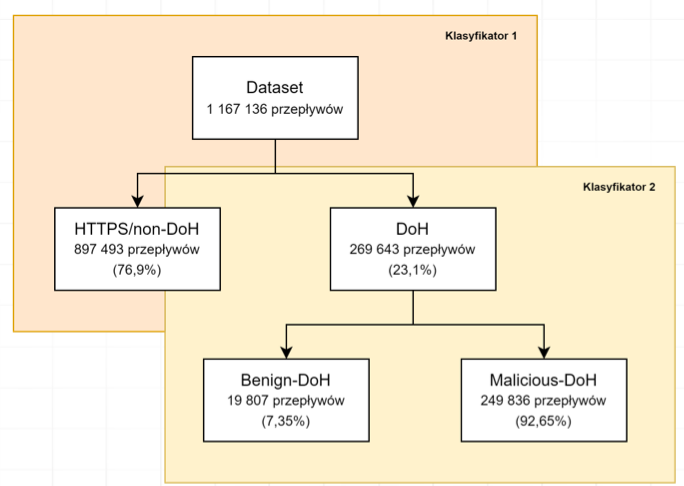

## Zmienne zależne:

+ 0 - nie-DoH: Ruch generowany przez dostęp do strony, która używa protokołu HTTPS jest przechwytywany i oznaczany jako ruch nie-DoH.

+ 1 - Regularny DoH to nie-złośliwy ruch DoH generowany przy użyciu tej samej techniki co wspomniany nie-DoH.

+ 2 - złośliwy-DoH: Narzędzia tunelowania DNS takie jak dns2tcp, DNSCat2 i Iodine były użyte do generowania złośliwego ruchu DoH. Narzędzia te potrafią wysyłać ruch TCP zakodowany w zapytaniach DNS przy pomocy zaszyfrowanych danych DoH.

Wśród zbioru danych można zdefiniować niektóre z cech:
- **Współczynnik zmienności** - statystyczna miara względnego rozproszenia
punktów danych w serii danych wokół średniej. Matematycznie, CV = σ/µ,
gdzie σ i µ oznaczają odpowiednio odchylenie standardowe i średnią.
- **Odchylenie od mediany** - mierzy asymetrię rozkładu prawdopodobieństwa zmiennej losowej od rzeczywistej wartości wokół jej mediany.
- **Odchylenie od mody** - mierzy asymetrię rozkładu prawdopodobieństwa zmiennej losowej od rzeczywistej wartości wokół jej mody.

W oparciu o powyższe definicje, te trzy cechy są obliczane dla długości pakietu,
czasu pakietu oraz różnicy czasu żądania/odpowiedzi.

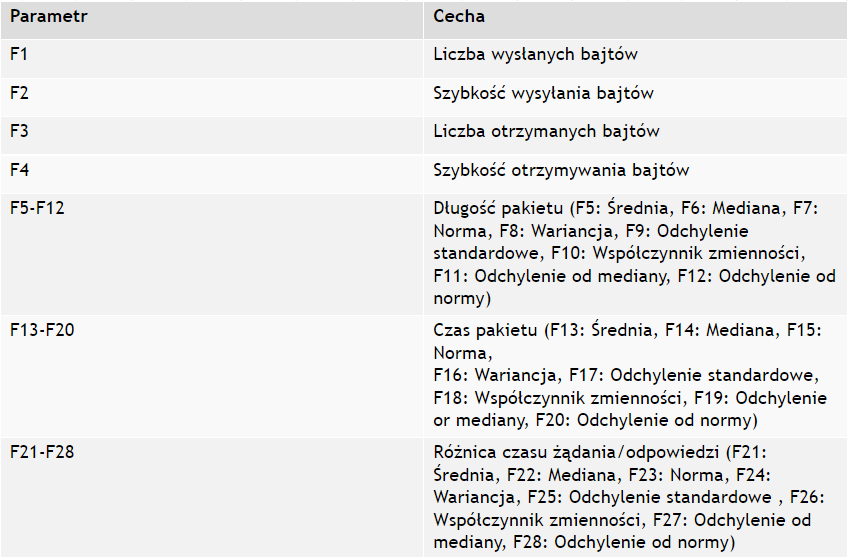

# 3. Przygotowanie danych

Zbiór danych odpowiednio oznaczono zmiennymi zależnymi oraz usunięto z niego podstawowe informacje, nieistotne dla analizy (źródłowe i docelowe adresy ip wraz z numerami portów, znaczniki czasowe)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df1 = pd.read_csv("drive/MyDrive/l2-malicious.csv")
df1 = df1.dropna()
df1.columns = df1.columns.str.replace('Label','FlowType')
df1 = df1.replace("Malicious", 2)

df2 = pd.read_csv("drive/MyDrive/l1-nondoh.csv")
df2 = df2.dropna()
df2.columns = df2.columns.str.replace('Label','FlowType')
df2 = df2.replace("NonDoH", 0)

df3 = pd.read_csv("drive/MyDrive/l2-benign.csv")
df3 = df3.dropna()
df3.columns = df3.columns.str.replace('Label','FlowType')
df3 = df3.replace("Benign", 1)

frames = [df1, df2, df3]
df = pd.concat(frames)
df.shape

(1159108, 35)

In [ ]:
df.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,FlowType
0,192.168.20.205,8.8.4.4,41018,443,2020-03-25 04:40:42,120.731389,46446,384.705257,85465,707.893786,...,0.622162,0.000070,0.008369,0.011880,0.015244,0.015221,-1.205904,-0.399220,0.704513,2
1,8.8.4.4,192.168.20.205,443,41018,2020-03-25 04:42:42,120.052751,470548,3919.510349,227661,1896.341384,...,0.331509,0.023756,0.154130,0.037553,0.000049,0.000039,0.729988,0.243394,4.104293,2
2,8.8.4.4,192.168.20.205,443,41018,2020-03-25 04:44:42,120.034398,747083,6223.907584,355181,2958.993471,...,0.579348,0.000276,0.016611,0.011986,0.000048,0.000030,2.156008,0.719753,1.385888,2
3,8.8.4.4,192.168.20.205,443,41018,2020-03-25 04:46:42,120.004804,745382,6211.268009,354606,2954.931704,...,0.580188,0.000271,0.016473,0.011724,0.000049,0.000031,2.126128,0.709802,1.405118,2
4,8.8.4.4,192.168.20.205,443,41018,2020-03-25 04:48:42,120.025620,749888,6247.732776,356531,2970.457474,...,0.578922,0.000271,0.016458,0.011725,0.000048,0.000031,2.128463,0.710521,1.403698,2


In [ ]:
X = df.drop(df.columns[[0,1,2,3,4,5,34]], axis='columns')
Y = df['FlowType']
Y = Y.astype('int')
X.head()

,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,PacketLengthMedian,PacketLengthMode,PacketLengthSkewFromMedian,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
0,46446,384.705257,85465,707.893786,5668.351021,75.288452,117.046140,107.0,68,0.400306,...,0.297513,0.622162,0.000070,0.008369,0.011880,0.015244,0.015221,-1.205904,-0.399220,0.704513
1,470548,3919.510349,227661,1896.341384,8083.727768,89.909553,128.347243,107.0,68,0.712291,...,-0.725377,0.331509,0.023756,0.154130,0.037553,0.000049,0.000039,0.729988,0.243394,4.104293
2,747083,6223.907584,355181,2958.993471,8571.035514,92.579887,129.434476,107.0,68,0.726977,...,0.033274,0.579348,0.000276,0.016611,0.011986,0.000048,0.000030,2.156008,0.719753,1.385888
3,745382,6211.268009,354606,2954.931704,8553.829399,92.486915,129.227914,107.0,68,0.721007,...,1.624196,0.580188,0.000271,0.016473,0.011724,0.000049,0.000031,2.126128,0.709802,1.405118
4,749888,6247.732776,356531,2970.457474,8529.864415,92.357265,129.209272,107.0,68,0.721414,...,-1.096665,0.578922,0.000271,0.016458,0.011725,0.000048,0.000031,2.128463,0.710521,1.403698


In [ ]:
test = X.columns.values
print(test)

['FlowBytesSent' 'FlowSentRate' 'FlowBytesReceived' 'FlowReceivedRate'
 'PacketLengthVariance' 'PacketLengthStandardDeviation' 'PacketLengthMean'
 'PacketLengthMedian' 'PacketLengthMode' 'PacketLengthSkewFromMedian'
 'PacketLengthSkewFromMode' 'PacketLengthCoefficientofVariation'
 'PacketTimeVariance' 'PacketTimeStandardDeviation' 'PacketTimeMean'
 'PacketTimeMedian' 'PacketTimeMode' 'PacketTimeSkewFromMedian'
 'PacketTimeSkewFromMode' 'PacketTimeCoefficientofVariation'
 'ResponseTimeTimeVariance' 'ResponseTimeTimeStandardDeviation'
 'ResponseTimeTimeMean' 'ResponseTimeTimeMedian' 'ResponseTimeTimeMode'
 'ResponseTimeTimeSkewFromMedian' 'ResponseTimeTimeSkewFromMode'
 'ResponseTimeTimeCoefficientofVariation']


# 4. Algorytm Decision Tree

Algorytm Decision Tree to algorytm uczenia maszynowego, który wykorzystuje model podobny do drzewa decyzyjnego lub przewidywań na podstawie cech wejściowych. Rekursywnie dzieli dane na podstawie różnych wartości cech, tworząc gałęzie i węzły w drzewie. Każdy węzeł reprezentuje cechę, a każda gałąź reprezentuje możliwy wynik. Algorytm uczy się na podstawie oznaczonych danych treningowych, aby określić najlepsze podziały i decyzje w każdym węźle, optymalizując dokładność lub inne zdefiniowane metryki. Podczas tworzenia prognoz, algorytm przemierza drzewo od korzenia do węzła liścia, podążając za odpowiednimi gałęziami w oparciu o wartości cech wejściowych, i dostarcza odpowiednie wyjście lub przewidywania związane z tym węzłem liścia. Drzewa decyzyjne są powszechnie stosowane do zadań klasyfikacji i regresji w różnych dziedzinach, zapewniając interpretację i zdolność do obsługi zarówno danych kategorycznych, jak i liczbowych.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from time import process_time
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

clf = DecisionTreeClassifier()

start = process_time()
clf = clf.fit(X_train, Y_train)
end = process_time()
print(end - start)



80.43293957100013


In [ ]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
X_test

,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,PacketLengthMedian,PacketLengthMode,PacketLengthSkewFromMedian,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
161603,1741,100.974746,6695,388.297485,235489.750000,485.272861,351.500000,92.0,54,1.604252,...,0.380617,2.520331,5.981861e-04,0.024458,0.044359,0.044964,0.000861,-0.074271,1.778468,0.551368
886469,1449,4750.819672,4007,13137.704918,548024.543210,740.286798,303.111111,70.0,54,0.944679,...,2.193359,0.455922,5.963844e-04,0.024421,0.053548,0.063979,0.005282,-1.281349,1.976432,0.456054
311867,1279,753.314969,3448,2030.828782,214943.715556,463.620228,315.133333,62.0,54,1.637979,...,0.605689,1.478800,3.329977e-05,0.005771,0.028599,0.025306,0.025190,1.711825,0.590710,0.201778
318223,55,2016.424696,66,2419.709635,30.250000,5.500000,60.500000,60.5,55,0.000000,...,1.000000,1.000000,0.000000e+00,0.000000,0.027276,0.027276,0.027276,-10.000000,-10.000000,0.000000
2095,496,4.105383,448,3.708088,9.000000,3.000000,59.000000,59.0,56,0.000000,...,1.705470,0.586349,9.384844e-10,0.000031,15.089042,15.089030,15.088996,1.211861,1.513807,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98950,1806,53.863696,4828,143.994420,145522.872771,381.474603,228.758621,76.0,68,1.201327,...,0.624118,1.602261,5.934359e-05,0.007703,0.010935,0.015285,0.000008,-1.693867,1.418508,0.704450
47599,55,1932.061685,66,2318.474023,30.250000,5.500000,60.500000,60.5,55,0.000000,...,1.000000,1.000000,0.000000e+00,0.000000,0.028467,0.028467,0.028467,-10.000000,-10.000000,0.000000
283682,55,2220.159044,66,2664.190853,30.250000,5.500000,60.500000,60.5,55,0.000000,...,1.000000,1.000000,0.000000e+00,0.000000,0.024773,0.024773,0.024773,-10.000000,-10.000000,0.000000
643757,55,2189.577611,66,2627.493133,30.250000,5.500000,60.500000,60.5,55,0.000000,...,1.000000,1.000000,0.000000e+00,0.000000,0.025119,0.025119,0.025119,-10.000000,-10.000000,0.000000


In [ ]:
predictions = clf.predict(X_test)
predictions

array([2, 0, 0, ..., 2, 0, 0])

In [ ]:
clf.predict_proba(X_test)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predictions)

0.9963204527611702

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predictions, labels=[0,1,2])
# Lista pokazuje ile razy dobrze trafił per row i ile razy błędnie.

array([[177855,    387,     25],
       [   396,   3587,      3],
       [    40,      2,  49527]])

In [ ]:
from sklearn.metrics import precision_score
precision_score(Y_test, predictions, average='micro')

0.9963204527611702

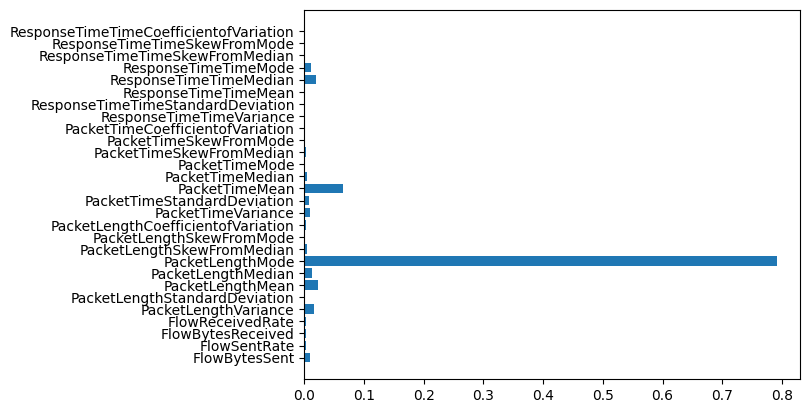

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y = clf.feature_importances_

y_pos = np.arange(len(test))
plt.barh(y_pos, y, align='center')
plt.yticks(y_pos, test)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


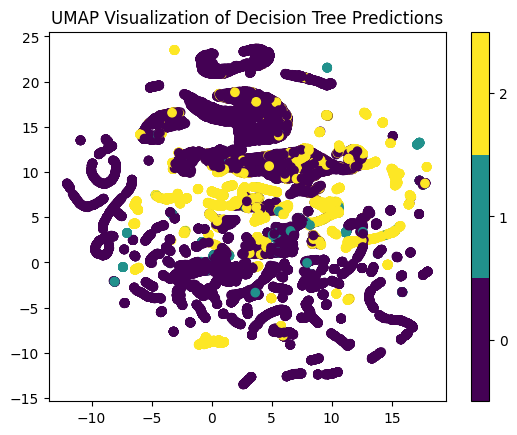

In [ ]:
y_pred = clf.predict(X_test)

# Generate UMAP visualization for predictions
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_test)

# Plot the UMAP visualization
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_pred, cmap='viridis')
plt.colorbar(boundaries=np.arange(np.max(y_pred)+2)-0.5).set_ticks(np.arange(np.max(y_pred)+1))
plt.title('Wizualizacja UMAP na podstawie predykcji algorytmu Decision Tree')
plt.show()

In [ ]:
from tabulate import tabulate

i = 0
results = []

for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
  clf = DecisionTreeClassifier()
  start = process_time()
  clf = clf.fit(X_train, Y_train)
  end = process_time()
  time = end - start
  predictions = clf.predict(X_test)
  a = precision_score(Y_test, predictions, average='micro')
  b = accuracy_score(Y_test, predictions)
  i = i + 1
  results.append([i,a,b, time])

col_names = ["Numer próby", "Precyzja", "Dokładność", "Długość nauki[s]"]
print(tabulate(results, headers=col_names))

  Numer próby    Precyzja    Dokładność    Długość nauki
-------------  ----------  ------------  ---------------
            1    0.996329      0.996329          82.6184
            2    0.996359      0.996359          82.8867
            3    0.9962        0.9962            79.2304
            4    0.996157      0.996157          82.1111
            5    0.996342      0.996342          89.7878
            6    0.996389      0.996389          83.8418
            7    0.996476      0.996476          81.8864
            8    0.996402      0.996402          81.3428
            9    0.996467      0.996467          84.2928
           10    0.996204      0.996204          84.7265


In [ ]:
import statistics

precyzja = []
dokladnosc = []
dlugosc = []
labels = ["Pomiar", "Mediania", "Odchylenie", "Średnia"]
table = []

for i in range(len(results)):
  precyzja.append(results[i][1])
  dokladnosc.append(results[i][2])
  dlugosc.append(results[i][3])

table.append([col_names[1], statistics.median(precyzja), statistics.stdev(precyzja), statistics.mean(precyzja)])
table.append([col_names[2], statistics.median(dokladnosc), statistics.stdev(dokladnosc), statistics.mean(dokladnosc)])
table.append([col_names[3], statistics.median(dlugosc), statistics.stdev(dlugosc), statistics.mean(dlugosc)])
print(tabulate(table, headers=labels))

Pomiar           Mediania    Odchylenie    Średnia
-------------  ----------  ------------  ---------
Precyzja         0.996351   0.000111911   0.996333
Dokładność       0.996351   0.000111911   0.996333
Długość nauki   82.7526     2.78563      83.2725


# 5. Algorytm RF

Algorytm Random Forest jest algorytmem uczenia maszynowego, który łączy wiele drzew decyzyjnych, aby dokonać przewidywań lub decyzji. Tworzy on zbiór drzew decyzyjnych, gdzie każde drzewo jest trenowane na losowym podzbiorze danych treningowych i losowych podzbiorach cech wejściowych. Podczas szkolenia, każde drzewo decyzyjne w lesie uczy się niezależnie od innych.

Podczas tworzenia predykcji, każde drzewo w lesie losowym niezależnie generuje predykcję, a ostateczna predykcja jest określana przez agregację predykcji wszystkich drzew. Ta agregacja może być wykonana przez wzięcie większości głosów w problemach klasyfikacji lub uśrednienie przewidywań w problemach regresji.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from time import process_time

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

clf = RandomForestClassifier(verbose=True)

start = process_time()
clf = clf.fit(X_train, Y_train)
end = process_time()
print(end - start)

start = process_time()
predictions = clf.predict(X_test)
end = process_time()
print(end - start)
print(predictions)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions, labels=[0,1,2]))
print(precision_score(Y_test, predictions, average='micro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 13.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


803.550941707
4.66607976399996
[0 0 0 ... 0 0 0]
0.997843172779115
[[177934     89      0]
 [   395   3516      0]
 [    16      0  49872]]
0.997843172779115


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


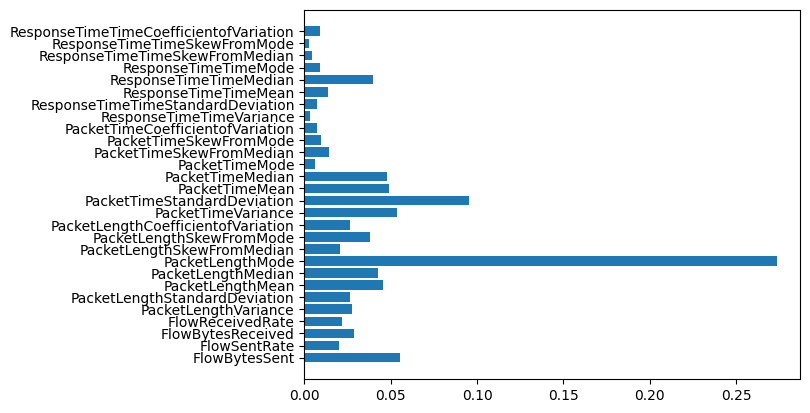

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y = clf.feature_importances_

y_pos = np.arange(len(test))
plt.barh(y_pos, y, align='center')
plt.yticks(y_pos, test)
plt.show()

In [ ]:
!pip install umap-learn
!pip install holoviews
!pip install -U ipykernel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel~=5.5.6, but you have ipykernel 6.23.1 which is incompatible.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


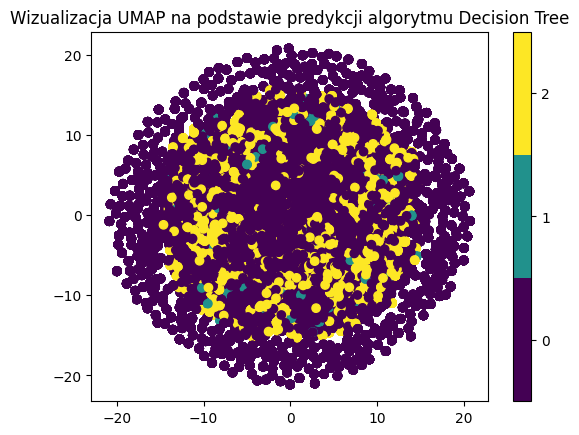

In [ ]:
import umap

y_pred = clf.predict(X_test)

# Generate UMAP visualization for predictions
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_test)

# Plot the UMAP visualization
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_pred, cmap='viridis')
plt.colorbar(boundaries=np.arange(np.max(y_pred)+2)-0.5).set_ticks(np.arange(np.max(y_pred)+1))
plt.title('Wizualizacja UMAP na podstawie predykcji algorytmu Random Forest')
plt.show()

In [ ]:
from tabulate import tabulate

i = 0
results = []

for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
  clf = RandomForestClassifier()
  start = process_time()
  clf = clf.fit(X_train, Y_train)
  end = process_time()
  time = end - start
  predictions = clf.predict(X_test)
  a = precision_score(Y_test, predictions, average='micro')
  b = accuracy_score(Y_test, predictions)
  i = i + 1
  results.append([i,a,b, time])

col_names = ["Numer próby", "Precyzja", "Dokładność", "Długość nauki[s]"]
print(tabulate(results, headers=col_names))

import statistics

precyzja = []
dokladnosc = []
dlugosc = []
labels = ["Pomiar", "Mediania", "Odchylenie", "Średnia"]
table = []

for i in range(len(results)):
  precyzja.append(results[i][1])
  dokladnosc.append(results[i][2])
  dlugosc.append(results[i][3])

table.append([col_names[1], statistics.median(precyzja), statistics.stdev(precyzja), statistics.mean(precyzja)])
table.append([col_names[2], statistics.median(dokladnosc), statistics.stdev(dokladnosc), statistics.mean(dokladnosc)])
table.append([col_names[3], statistics.median(dlugosc), statistics.stdev(dlugosc), statistics.mean(dlugosc)])
print(tabulate(table, headers=labels))

  Numer próby    Precyzja    Dokładność    Długość nauki[s]
-------------  ----------  ------------  ------------------
            1    0.997869      0.997869             819.607
            2    0.997593      0.997593             822.039
            3    0.997791      0.997791             864.931
            4    0.997865      0.997865             828.118
            5    0.997809      0.997809             825.111
            6    0.997787      0.997787             842.579
            7    0.997869      0.997869             854.054
            8    0.997701      0.997701             839.037
            9    0.99774       0.99774              872.946
           10    0.997891      0.997891             848.998
Pomiar              Mediania    Odchylenie     Średnia
----------------  ----------  ------------  ----------
Precyzja              0.9978   9.30079e-05    0.997791
Dokładność            0.9978   9.30079e-05    0.997791
Długość nauki[s]    840.808   18.4515       841.742


# 6. Algorytm MLP

Algorytm MLP, znany również jako Multi-Layer Perceptron, jest rodzajem sieci neuronowej używanej do zadań klasyfikacji w uczeniu maszynowym. Jest on oparty na koncepcji sieci neuronowej typu feedforward, składającej się z wielu warstw połączonych ze sobą sztucznych neuronów lub węzłów.

Algorytm uczy się na podstawie oznaczonych danych treningowych, aby dostosować wagi i uprzedzenia sieci neuronowej, umożliwiając jej dokonywanie przewidywań na niewidzianych danych. Wykorzystuje on proces zwany propagacją wsteczną, w którym błędy w przewidywaniach są propagowane wstecz przez sieć, a wagi są odpowiednio aktualizowane, aby zminimalizować błąd.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from time import process_time

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.02)

clf = MLPClassifier(verbose=True)

start = process_time()
clf = clf.fit(X_train, Y_train)
end = process_time()
print(f"Fit time: {end - start}")

start = process_time()
predictions = clf.predict(X_test)
end = process_time()
print(end - start)
print(f"Predict time: {predictions}")

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions, labels=[0,1,2]))
print(precision_score(Y_test, predictions, average='micro'))

Iteration 1, loss = 5.23634219
Iteration 2, loss = 3.84253781
Iteration 3, loss = 3.36864483
Iteration 4, loss = 2.91683573
Iteration 5, loss = 2.46380519
Iteration 6, loss = 2.24418915
Iteration 7, loss = 1.96514447
Iteration 8, loss = 1.85428583
Iteration 9, loss = 1.73550544
Iteration 10, loss = 1.64740516
Iteration 11, loss = 1.57046143
Iteration 12, loss = 1.46803087
Iteration 13, loss = 1.34363466
Iteration 14, loss = 1.29121762
Iteration 15, loss = 1.18891626
Iteration 16, loss = 1.12171581
Iteration 17, loss = 1.01620520
Iteration 18, loss = 0.92033468
Iteration 19, loss = 0.74674021
Iteration 20, loss = 0.62503922
Iteration 21, loss = 0.42471480
Iteration 22, loss = 0.31347558
Iteration 23, loss = 0.26395742
Iteration 24, loss = 0.25323780
Iteration 25, loss = 0.25465633
Iteration 26, loss = 0.30732159
Iteration 27, loss = 0.44107117
Iteration 28, loss = 0.42029625
Iteration 29, loss = 0.40974880
Iteration 30, loss = 0.40990791
Iteration 31, loss = 0.39436564
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


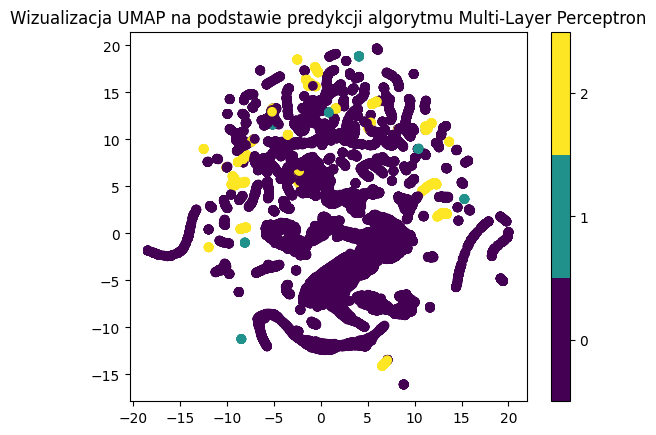

In [ ]:
import umap

y_pred = clf.predict(X_test)

# Generate UMAP visualization for predictions
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_test)

# Plot the UMAP visualization
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_pred, cmap='viridis')
plt.colorbar(boundaries=np.arange(np.max(y_pred)+2)-0.5).set_ticks(np.arange(np.max(y_pred)+1))
plt.title('Wizualizacja UMAP na podstawie predykcji algorytmu Multi-Layer Perceptron')
plt.show()

In [ ]:
from tabulate import tabulate

i = 0
results = []

for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
  clf = MLPClassifier()
  start = process_time()
  clf = clf.fit(X_train, Y_train)
  end = process_time()
  time = end - start
  predictions = clf.predict(X_test)
  a = precision_score(Y_test, predictions, average='micro')
  b = accuracy_score(Y_test, predictions)
  i = i + 1
  results.append([i,a,b, time])

col_names = ["Numer próby", "Precyzja", "Dokładność", "Długość nauki[s]"]
print(tabulate(results, headers=col_names))

import statistics

precyzja = []
dokladnosc = []
dlugosc = []
labels = ["Pomiar", "Mediania", "Odchylenie", "Średnia"]
table = []

for i in range(len(results)):
  precyzja.append(results[i][1])
  dokladnosc.append(results[i][2])
  dlugosc.append(results[i][3])

table.append([col_names[1], statistics.median(precyzja), statistics.stdev(precyzja), statistics.mean(precyzja)])
table.append([col_names[2], statistics.median(dokladnosc), statistics.stdev(dokladnosc), statistics.mean(dokladnosc)])
table.append([col_names[3], statistics.median(dlugosc), statistics.stdev(dlugosc), statistics.mean(dlugosc)])
print(tabulate(table, headers=labels))

  Numer próby    Precyzja    Dokładność    Długość nauki[s]
-------------  ----------  ------------  ------------------
            1    0.812028      0.812028            1203.12
            2    0.933928      0.933928            3334.42
            3    0.815307      0.815307             922.272
            4    0.799506      0.799506             936.637
            5    0.795731      0.795731            1465.51
            6    0.797297      0.797297            3437.44
            7    0.933134      0.933134            1743.88
            8    0.817291      0.817291            1029.64
            9    0.789541      0.789541            5287.13
           10    0.829762      0.829762             866.049
Pomiar               Mediania    Odchylenie      Średnia
----------------  -----------  ------------  -----------
Precyzja             0.813667      0.054664     0.832352
Dokładność           0.813667      0.054664     0.832352
Długość nauki[s]  1334.32       1496.4       2022.61


5. **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from time import process_time
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

clf = KNeighborsClassifier()

start = process_time()
clf = clf.fit(X_train, Y_train)
end = process_time()
print(end - start)



0.3483484030000028


In [ ]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
X_test

,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,PacketLengthMedian,PacketLengthMode,PacketLengthSkewFromMedian,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
834089,1556,9148.313206,3500,20577.825335,186817.160000,432.223507,252.800000,70.0,66,1.268788,...,2.149217,0.465286,0.000286,0.016914,0.019834,0.033671,0.000018,-2.454269,1.171547,0.852798
540041,147,2285.589900,93,1445.985447,338.000000,18.384776,80.000000,93.0,93,-2.121320,...,1.101260,0.908051,0.000000,0.000000,0.023478,0.023478,0.023478,-10.000000,-10.000000,0.000000
376302,574,14.033589,30787,752.703990,458775.236159,677.329489,922.382353,1385.0,1514,-2.049007,...,-0.250190,0.249951,0.000047,0.006838,0.005547,0.001375,0.000080,1.830443,0.799466,1.232793
764313,55,1853.099730,60,2021.563342,6.250000,2.500000,57.500000,57.5,55,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.029680,0.029680,0.029680,-10.000000,-10.000000,0.000000
4914,1085,768.265603,4100,2903.123478,417864.094183,646.424082,272.894737,68.0,68,0.950899,...,1.241292,0.805612,0.009060,0.095186,0.064274,0.025385,0.000010,1.225701,0.675144,1.480935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558010,171,1991.683846,105,1222.963765,338.000000,18.384776,92.000000,105.0,105,-2.121320,...,1.414214,0.707107,0.000000,0.000000,0.085832,0.085832,0.085832,-10.000000,-10.000000,0.000000
97357,1153,489.736141,4101,1741.897585,189287.010000,435.071270,262.700000,72.0,68,1.314957,...,1.127050,0.887272,0.000939,0.030643,0.020641,0.015516,0.000006,0.501712,0.673383,1.484607
166367,139549,1162.223367,284420,2368.770612,9087.724083,95.329555,127.356263,107.0,68,0.640607,...,2.797180,0.357503,0.000064,0.008029,0.010680,0.015174,0.015162,-1.679127,-0.558214,0.751768
15709,143604,1594.117630,235460,2613.791657,20092.999919,141.749779,225.365042,259.0,68,-0.711852,...,1.616799,0.618506,0.000856,0.029253,0.021740,0.015574,0.015364,0.632436,0.217974,1.345558


In [ ]:
predictions = clf.predict(X_test)
predictions

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
clf.predict_proba(X_test)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predictions)

0.9873437378678469

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predictions, labels=[0,1,2])
# Lista pokazuje ile razy dobrze trafił per row i ile razy błędnie.

array([[176821,    315,   1096],
       [   576,   3203,    157],
       [   737,     53,  48864]])

In [ ]:
from sklearn.metrics import precision_score
precision_score(Y_test, predictions, average='micro')

0.9873437378678469

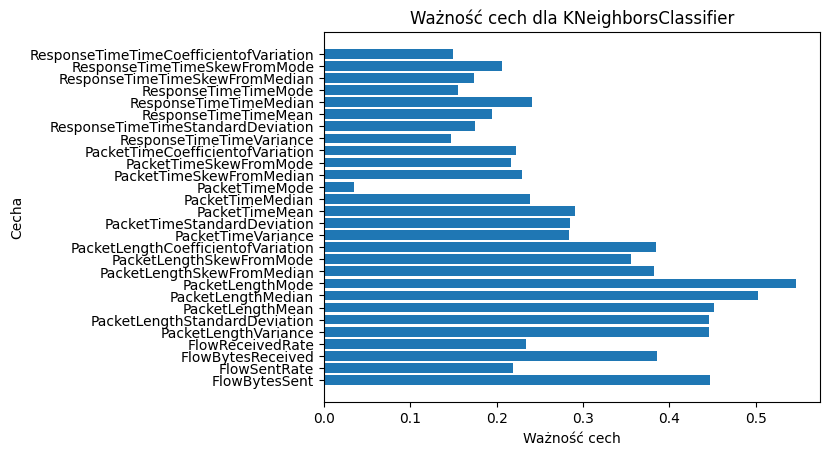

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import matplotlib.pyplot as plt

# Tworzenie obiektu SelectKBest z metryką MI
selector = SelectKBest(score_func=mutual_info_classif, k=5)
selector.fit(X_train, Y_train)

# Pobieranie ważności cech
ważności_cech = selector.scores_

# Tworzenie wykresu ważności cech
y_pos = np.arange(len(ważności_cech))
plt.barh(y_pos, ważności_cech, align='center')
plt.yticks(y_pos, test)  # `test` to lista nazw cech
plt.xlabel('Ważność cech')
plt.ylabel('Cecha')
plt.title('Ważność cech dla KNeighborsClassifier')
plt.show()


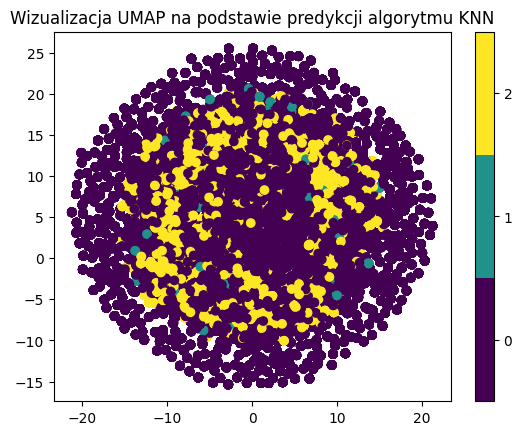

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_pred, cmap='viridis')
plt.colorbar(boundaries=np.arange(np.max(y_pred)+2)-0.5).set_ticks(np.arange(np.max(y_pred)+1))
plt.title('Wizualizacja UMAP na podstawie predykcji algorytmu KNN')
plt.show()

In [ ]:
from tabulate import tabulate
from sklearn.model_selection import train_test_split
i = 0
results = []

for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
  clf = KNeighborsClassifier()
  start = process_time()
  clf = clf.fit(X_train, Y_train)
  end = process_time()
  time = end - start
  predictions = clf.predict(X_test)
  a = precision_score(Y_test, predictions, average='micro')
  b = accuracy_score(Y_test, predictions)
  i = i + 1
  results.append([i,a,b, time])

col_names = ["Numer próby", "Precyzja", "Dokładność", "Długość nauki[s]"]
print(tabulate(results, headers=col_names))

  Numer próby    Precyzja    Dokładność    Długość nauki[s]
-------------  ----------  ------------  ------------------
            1    0.987706      0.987706            0.717515
            2    0.987818      0.987818            0.39251
            3    0.987689      0.987689            0.2598
            4    0.987598      0.987598            0.366561
            5    0.987115      0.987115            0.241835
            6    0.987085      0.987085            0.295464
            7    0.987309      0.987309            0.242172
            8    0.987676      0.987676            0.239552
            9    0.986999      0.986999            0.244798
           10    0.987654      0.987654            0.244641


In [ ]:
6. AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from time import process_time
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

clf = AdaBoostClassifier()

start = process_time()
clf = clf.fit(X_train, Y_train)
end = process_time()
print(end - start)

In [ ]:
predictions = clf.predict(X_test)
predictions

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predictions)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predictions, labels=[0,1,2])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y = clf.feature_importances_

y_pos = np.arange(len(test))
plt.barh(y_pos, y, align='center')
plt.yticks(y_pos, test)
plt.show()

In [ ]:
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
i = 0
results = []

for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
  clf = AdaBoostClassifier()
  start = process_time()
  clf = clf.fit(X_train, Y_train)
  end = process_time()
  time = end - start
  predictions = clf.predict(X_test)
  a = precision_score(Y_test, predictions, average='micro')
  b = accuracy_score(Y_test, predictions)
  i = i + 1
  results.append([i,a,b, time])

col_names = ["Numer próby", "Precyzja", "Dokładność", "Długość nauki[s]"]
print(tabulate(results, headers=col_names))

# 7. Podsumowanie, wnioski


w raporcie